<a href="https://colab.research.google.com/github/ManGuo1130/Synergistic-effect-evaluation/blob/main/R_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch torch-geometric pandas scikit-learn

# 数据准备

##处理节点数据

In [55]:
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 加载节点特征
node_features = pd.read_csv("/content/node_features.csv")
weights_all = pd.read_csv("/content/weights_all.csv")

# 查看数据结构
print(node_features.head())
print(weights_all.head())

   Unnamed: 0   地市        lat         lon       协同度  常住人口  城市建设用地占市区.面积比重  \
0           1  安庆市  30.576049  116.486728  0.549207   417           15.68   
1           2  常州市  31.625341  119.637182  0.784272   528            9.62   
2           3  池州市  30.284429  117.365321  0.660851   134            1.61   
3           4  滁州市  32.544120  118.102548  0.739916   399            6.55   
4           5  杭州市  29.900238  119.469934  0.729286  1197            7.38   

   地区生产总值  人均地区生产总值  第二产业占地区生产总值的比重  第三产业占地区生产总值的比重  工业企业数  专利授权数  绿化覆盖率  \
0    2468     58684           43.23           47.04   1644   5479  39.49   
1    7805    147939           46.33           51.57   5065  41321  43.30   
2     869     64843           44.07           45.80    539   2374  46.13   
3    3032     76087           48.75           42.28   1870   8654  42.30   
4   16106    136617           29.93           68.04   5992  92399  43.36   

   OBJECTID  
0         1  
1         2  
2         3  
3         4  
4         

In [56]:
# 编码节点ID为整数索引
le = LabelEncoder()
node_features['ID_encoded'] = le.fit_transform(node_features['OBJECTID'])

# 创建ID到索引的映射
id_to_index = {id_: idx for idx, id_ in enumerate(node_features['OBJECTID'])}

In [57]:
print(id_to_index)

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26}


In [58]:
# 准备节点特征矩阵
feature_columns = [
    '常住人口', '城市建设用地占市区.面积比重', '地区生产总值',
    '人均地区生产总值', '第二产业占地区生产总值的比重',
    '第三产业占地区生产总值的比重', '工业企业数', '专利授权数',
    '绿化覆盖率'
]

In [59]:
X = node_features[feature_columns].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = torch.tensor(X, dtype=torch.float)

In [60]:
print(X)

tensor([[-0.4836,  0.5847, -0.6946, -1.5759, -0.0449, -0.6489, -0.8534, -0.9024,
         -1.5415],
        [-0.2507, -0.2169, -0.0059,  1.1647,  0.4802, -0.0193,  0.3622,  0.0792,
          0.1763],
        [-1.0775, -1.2764, -0.9010, -1.3868,  0.0974, -0.8213, -1.2461, -0.9874,
          1.4523],
        [-0.5214, -0.6230, -0.6219, -1.0415,  0.8901, -1.3106, -0.7731, -0.8154,
         -0.2745],
        [ 1.1533, -0.5132,  1.0653,  0.8171, -2.2975,  2.2701,  0.6916,  1.4780,
          0.2034],
        [ 0.6077,  3.0939,  0.2833, -0.0485, -1.3304,  1.2999, -0.6736,  0.0719,
         -0.4143],
        [-0.6515, -0.4325, -0.6001, -0.4430,  1.0357, -0.7907, -0.0902, -0.5674,
          1.5425],
        [-0.2234,  0.3069, -0.3021, -0.2293,  1.4270, -0.8171,  0.8238, -0.0949,
         -0.8967],
        [ 0.1229, -0.7923, -0.4061, -1.3105, -0.8358,  0.8884,  0.2073,  0.1100,
         -0.6172],
        [-0.9054,  0.2064, -0.7309, -0.2762,  0.7343, -0.5641, -1.0347, -0.8380,
          1.5199],


In [61]:
# 准备目标变量（协同度）
y = torch.tensor(node_features['协同度'].values, dtype=torch.float).unsqueeze(1)

print(y)

tensor([[0.5492],
        [0.7843],
        [0.6609],
        [0.7399],
        [0.7293],
        [0.6852],
        [0.7373],
        [0.7180],
        [0.7326],
        [0.7303],
        [0.8068],
        [0.7315],
        [0.7429],
        [0.8088],
        [0.7640],
        [0.7647],
        [0.7240],
        [0.7559],
        [0.7059],
        [0.6741],
        [0.7913],
        [0.7221],
        [0.7767],
        [0.7872],
        [0.7936],
        [0.7640],
        [0.8117]])


## 构建图数据结果

In [62]:
# 映射ID到索引
weights_all['from_idx'] = weights_all['from'].map(id_to_index)
weights_all['to_idx'] = weights_all['to'].map(id_to_index)

In [63]:
# 处理关系类型
relation_le = LabelEncoder()
weights_all['relation_encoded'] = relation_le.fit_transform(weights_all['relation'])

In [64]:
# 准备边索引和边类型
edge_index = torch.tensor(weights_all[['from_idx', 'to_idx']].values, dtype=torch.long).t().contiguous()
edge_type = torch.tensor(weights_all['relation_encoded'].values, dtype=torch.long)

In [65]:
# 准备边权重
edge_weight = torch.tensor(weights_all['weights'].values, dtype=torch.float)

In [66]:
# 创建图数据对象
data = Data(x=X, edge_index=edge_index, edge_type=edge_type, edge_attr=edge_weight, y=y)

print(data)

Data(x=[27, 9], edge_index=[2, 4509], edge_attr=[4509], y=[27, 1], edge_type=[4509])


# 定义R-GCN模型

In [67]:
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv

In [68]:
class RGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations):
        super(RGCN, self).__init__()
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations)
        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations)

    def forward(self, data):
        x, edge_index, edge_type = data.x, data.edge_index, data.edge_type
        x = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_type)
        return x

In [69]:
# 模型参数
in_channels = X.shape[1]
hidden_channels = 16
out_channels = 1  # 预测协同度
num_relations = len(relation_le.classes_)

# 实例化模型
model = RGCN(in_channels, hidden_channels, out_channels, num_relations)

in_channels = X.shape[1]

确定输入特征的维度。
X 是之前准备好的节点特征张量，形状为 [num_nodes, num_features]。
X.shape[1] 获取特征的维度，即num_features，作为in_channels。
hidden_channels = 16

设置隐藏层的特征维度为16。
这是一个经验性选择，可以根据数据和模型表现进行调整。
out_channels = 1 # 预测协同度

设置输出层的特征维度为1，用于回归任务中预测每个节点的协同度。
num_relations = len(relation_le.classes_)

确定关系类型的数量。
relation_le 是之前定义并拟合的LabelEncoder对象，用于编码边的关系类型。
relation_le.classes_ 返回所有的关系类型，每种关系类型对应一个唯一的类别。
len(relation_le.classes_) 计算关系类型的总数，作为RGCNConv层中num_relations的参数。
model = RGCN(in_channels, hidden_channels, out_channels, num_relations)

使用之前定义的RGCN类实例化一个R-GCN模型对象。
参数解释：
in_channels: 输入特征维度，从节点特征矩阵X中获取。
hidden_channels: 隐藏层的特征维度，设置为16。
out_channels: 输出特征维度，设置为1，用于回归任务。
num_relations: 关系类型的数量，确保模型能区分不同类型的边。

In [70]:
# 定义损失函数和优化器
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 训练模型

## 数据集划分

In [71]:
# 设置随机种子以确保可重复性
torch.manual_seed(42)
np.random.seed(42)

# 获取节点数量
num_nodes = data.num_nodes

# 定义划分比例
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

In [72]:
# 确认比例总和为1
assert train_ratio + val_ratio + test_ratio == 1.0, "划分比例之和必须为1.0"

In [73]:
train_ratio + val_ratio + test_ratio

1.0

In [74]:
# 生成随机索引
indices = np.random.permutation(num_nodes)
train_size = int(train_ratio * num_nodes)
val_size = int(val_ratio * num_nodes)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# 创建掩码
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_indices] = True
val_mask[val_indices] = True
test_mask[test_indices] = True

# 将掩码添加到数据对象中
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

print(f"训练集节点数: {train_mask.sum().item()}")
print(f"验证集节点数: {val_mask.sum().item()}")
print(f"测试集节点数: {test_mask.sum().item()}")

训练集节点数: 18
验证集节点数: 4
测试集节点数: 5


In [75]:
def train(model, data, optimizer, criterion, epochs=100):
    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()

        # 前向传播
        out = model(data)

        # 仅计算训练集的损失
        loss = criterion(out[data.train_mask], data.y[data.train_mask])

        # 反向传播
        loss.backward()
        optimizer.step()

        # 计算验证集损失
        model.eval()
        with torch.no_grad():
            val_out = model(data)
            val_loss = criterion(val_out[data.val_mask], data.y[data.val_mask])

        if epoch % 10 == 0 or epoch == 1:
            print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

        # 保存最佳模型
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_state = model.state_dict().copy()
            torch.save(best_model_state, 'best_rgcn_model.pth')
            print(f'最佳模型参数已保存 (Val Loss: {best_val_loss:.4f})')

    print("训练完成。")

In [76]:
train(model, data, optimizer, criterion, epochs=500)

Epoch 1, Train Loss: 1.1616, Val Loss: 1.7079
最佳模型参数已保存 (Val Loss: 1.7079)
最佳模型参数已保存 (Val Loss: 1.3155)
最佳模型参数已保存 (Val Loss: 1.3151)
最佳模型参数已保存 (Val Loss: 1.1096)
最佳模型参数已保存 (Val Loss: 0.8242)
最佳模型参数已保存 (Val Loss: 0.7011)
最佳模型参数已保存 (Val Loss: 0.6751)
Epoch 10, Train Loss: 0.1462, Val Loss: 0.5821
最佳模型参数已保存 (Val Loss: 0.5821)
最佳模型参数已保存 (Val Loss: 0.5447)
最佳模型参数已保存 (Val Loss: 0.5383)
最佳模型参数已保存 (Val Loss: 0.5197)
最佳模型参数已保存 (Val Loss: 0.4977)
Epoch 20, Train Loss: 0.0360, Val Loss: 0.4759
最佳模型参数已保存 (Val Loss: 0.4759)
最佳模型参数已保存 (Val Loss: 0.4617)
最佳模型参数已保存 (Val Loss: 0.4502)
最佳模型参数已保存 (Val Loss: 0.4335)
最佳模型参数已保存 (Val Loss: 0.4185)
最佳模型参数已保存 (Val Loss: 0.4149)
最佳模型参数已保存 (Val Loss: 0.4128)
最佳模型参数已保存 (Val Loss: 0.3954)
最佳模型参数已保存 (Val Loss: 0.3748)
Epoch 30, Train Loss: 0.0154, Val Loss: 0.3630
最佳模型参数已保存 (Val Loss: 0.3630)
最佳模型参数已保存 (Val Loss: 0.3623)
Epoch 40, Train Loss: 0.0029, Val Loss: 0.3876
最佳模型参数已保存 (Val Loss: 0.3592)
Epoch 50, Train Loss: 0.0011, Val Loss: 0.3515
最佳模型参数已保存 (Val Loss: 0.

# 评估模型

In [77]:
# 加载最佳模型参数
model.load_state_dict(torch.load('best_rgcn_model.pth'))
model.eval()

RGCN(
  (conv1): RGCNConv(9, 16, num_relations=9)
  (conv2): RGCNConv(16, 1, num_relations=9)
)

Test Loss: 0.1056
Test MSE: 0.1056, Test R²: -52.5262


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21327 (\N{CJK UNIFIED IDEOGRAPH-534F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21516 (\N{CJK UNIFIED IDEOGRAPH-540C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

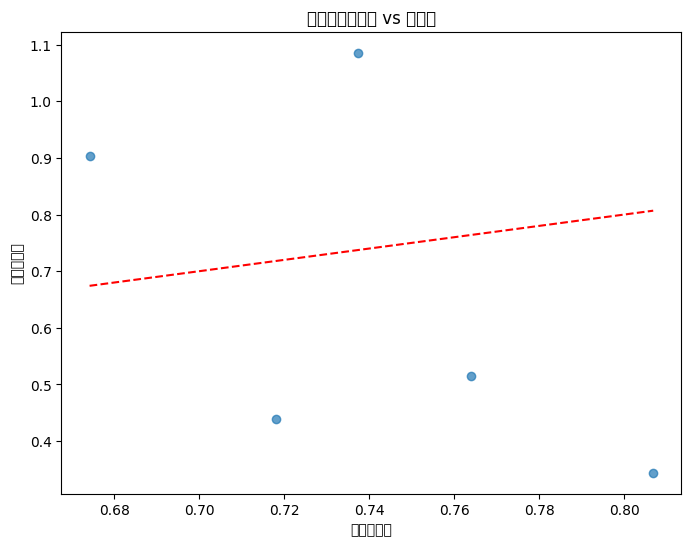

In [78]:
with torch.no_grad():
    predictions = model(data)

    # 损失计算
    test_loss = criterion(predictions[data.test_mask], data.y[data.test_mask])
    print(f'Test Loss: {test_loss.item():.4f}')

    # 转换为numpy数组
    preds = predictions[data.test_mask].numpy().flatten()
    targets = data.y[data.test_mask].numpy().flatten()

    # 计算MSE和R²
    mse = mean_squared_error(targets, preds)
    r2 = r2_score(targets, preds)
    print(f'Test MSE: {mse:.4f}, Test R²: {r2:.4f}')

    # 绘制真实值与预测值对比
    plt.figure(figsize=(8,6))
    plt.scatter(targets, preds, alpha=0.7)
    plt.xlabel('真实协同度')
    plt.ylabel('预测协同度')
    plt.title('测试集：真实值 vs 预测值')
    plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--')
    plt.show()

# 可解释性说明

In [111]:
import torch
from torch_geometric.explain import GNNExplainer, Explanation
from torch_geometric.explain.config import (
    ModelConfig,
    ExplainerConfig,
    MaskType
)
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# 配置模型
model_config = ModelConfig(
    mode='regression',  # 因为是回归任务
    task_level='node',  # 节点级任务
    return_type='raw'   # 返回原始输出
)

# 配置解释器
explainer_config = ExplainerConfig(
    explanation_type='model',  # 直接使用字符串
    node_mask_type='attributes',  # 直接使用字符串
    edge_mask_type='object'      # 直接使用字符串
)

# 初始化解释器
explainer = GNNExplainer(
    model=model,
    epochs=100,
    lr=0.01
)

# 连接配置
explainer.connect(
    model_config=model_config,
    explainer_config=explainer_config
)


In [131]:
explainer = GNNExplainer(
    model=model,
    epochs=100,
    lr=0.01
)

In [121]:
def analyze_node(node_idx):
    """分析单个节点的可解释性"""
    # 生成解释
    explanation = explainer(
        x=data.x,
        edge_index=data.edge_index,
        target=node_idx,
        model=model,
        edge_type=data.edge_type
    )

    # 打印解释对象的属性
    print("解释对象包含的属性：")
    for attr in dir(explanation):
        if not attr.startswith('_'):
            value = getattr(explanation, attr)
            if isinstance(value, (torch.Tensor, np.ndarray)):
                print(f"{attr}: shape = {value.shape}")
            else:
                print(f"{attr}: {type(value)}")

    return explanation

def visualize_explanation(explanation, node_idx, feature_names):
    """可视化解释结果"""
    # 1. 特征重要性可视化
    if hasattr(explanation, 'node_mask'):
        plt.figure(figsize=(10, 6))
        feature_imp = explanation.node_mask.detach().cpu().numpy()
        if len(feature_imp.shape) > 1:
            feature_imp = feature_imp[node_idx]

        # 归一化特征重要性
        feature_imp = (feature_imp - feature_imp.min()) / (feature_imp.max() - feature_imp.min())

        plt.bar(feature_names, feature_imp)
        plt.xticks(rotation=45, ha='right')
        plt.title(f'节点 {node_idx} 的特征重要性')
        plt.tight_layout()
        plt.show()

    # 2. 边重要性可视化
    if hasattr(explanation, 'edge_mask'):
        edge_mask = explanation.edge_mask.detach().cpu().numpy()

        G = nx.Graph()
        edge_index = data.edge_index.cpu().numpy()

        # 添加边
        for i in range(edge_index.shape[1]):
            src, dst = edge_index[0, i], edge_index[1, i]
            G.add_edge(int(src), int(dst))

        # 设置布局
        pos = nx.spring_layout(G)

        # 归一化边掩码
        edge_mask = (edge_mask - edge_mask.min()) / (edge_mask.max() - edge_mask.min())

        # 根据边掩码设置边的颜色和宽度
        edge_colors = []
        edge_widths = []
        threshold = 0.5  # 可以调整这个阈值

        for i, (u, v) in enumerate(G.edges()):
            if edge_mask[i] > threshold:
                edge_colors.append('red')
                edge_widths.append(2.0 * edge_mask[i])
            else:
                edge_colors.append('gray')
                edge_widths.append(0.5 * edge_mask[i])

        plt.figure(figsize=(12, 12))
        nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
        nx.draw_networkx_nodes(G, pos,
                             node_color=['orange' if n == node_idx else 'lightblue'
                                       for n in G.nodes()],
                             node_size=300)
        nx.draw_networkx_labels(G, pos)
        plt.title(f'节点 {node_idx} 的邻居重要性')
        plt.axis('off')
        plt.show()

In [117]:
model.eval()

RGCN(
  (conv1): RGCNConv(9, 16, num_relations=9)
  (conv2): RGCNConv(16, 1, num_relations=9)
)

In [118]:
print(model)

RGCN(
  (conv1): RGCNConv(9, 16, num_relations=9)
  (conv2): RGCNConv(16, 1, num_relations=9)
)


In [ ]:
node_idx = 10
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)

In [146]:
ax, G = explainer.visualize_subgraph(node_idx, edge_index, train_mask, y=data.y)
plt.show()

AttributeError: 'GNNExplainer' object has no attribute 'visualize_subgraph'